In [1]:
# Kernel conda_neuron_tensorflow_p38

In [2]:
#!pip install pillow

In [12]:
#!pip install matplotlib

In [3]:
import os
import boto3
import tensorflow as tf
from tensorflow.keras.models import load_model
import tensorflow.neuron as tfn
import shutil
import socket
import requests
#from tensorflow.keras.layers import Activation, Layer


# S3 configuration
s3_client = boto3.client('s3')
BUCKET_NAME = 'deeplabv3-model-bucket-2025'  # Update if different s3://deeplabv3-model-bucket-2025/keras_models/deeplab_v3_plus_384_Augmented_nolr_3_CLASSES.keras
MODEL_KEY = 'keras_models/deeplab_v3_plus_384_Augmented_nolr_3_CLASSES.keras'
TEMP_DIR = './temp'

MODEL_KERAS_PATH = os.path.join(TEMP_DIR, 'model.keras')
SAVED_MODEL_DIR = os.path.join(TEMP_DIR, 'deeplabv3_saved_model')
COMPILED_MODEL_DIR = os.path.join(TEMP_DIR, 'deeplabv3_neuronX')
OUTPUT_ZIP = 'deeplabv3_neuronX.zip'

image_path = '41f9e920-51b7-44c3-b417-d9ceb0db9ebd.jpg'

# Create temporary directories
os.makedirs(TEMP_DIR, exist_ok=True)
os.makedirs(SAVED_MODEL_DIR, exist_ok=True)
os.makedirs(COMPILED_MODEL_DIR, exist_ok=True)

2025-05-07 12:18:43.336828: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-07 12:18:43.436874: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/amazon/efa/lib64:/opt/amazon/openmpi/lib64:/opt/amazon/ofi-nccl/lib64:/usr/local/cuda-12.1/lib:/usr/local/cuda-12.1/lib64:/usr/local/cuda-12.1:/usr/local/cuda-12.1/extras/CUPTI/lib64:/usr/local/cuda-12.1/targets/x86_64-linux/lib/:/usr/local/lib:/usr/lib:/lib:/opt/amazon/efa/lib64:/opt/amazon/openmpi/lib64:/opt/amazon/ofi-nccl/lib64:/usr/local/cuda-12.1/lib:/usr/local/cuda-12.1/lib64:/usr/local/cuda-12.

In [4]:
# Step 1: Download the .keras model from S3
try:
    print("Downloading model from S3...")
    s3_client.download_file(BUCKET_NAME, MODEL_KEY, MODEL_KERAS_PATH)
except Exception as e:
    print(f"Error downloading from S3: {e}")
    raise

In [6]:
import tensorflow as tf
import tensorflow_neuronx as tfnx
from PIL import Image
import numpy as np
import os
import subprocess

# Enable verbose logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
os.environ['NEURON_RT_LOG_LEVEL'] = 'DEBUG'
os.environ['NEURON_CC_FLAGS'] = '--log-level DEBUG'

# Check Neuron device status
print("Neuron device status:")
subprocess.run(["neuron-ls"])

# Clear previous compilation artifacts
if os.path.exists(COMPILED_MODEL_DIR):
    import shutil
    shutil.rmtree(COMPILED_MODEL_DIR)

# Load model
try:
    model = tf.keras.models.load_model(MODEL_KERAS_PATH, compile=False)
    #model.summary()
except Exception as e:
    print("Failed to load model:", str(e))
    raise

# Compile for Neuron
input_shape = model.input_shape
input_shape = (1,) + input_shape[1:]
example_input = tf.random.normal(input_shape, dtype=tf.float32)
try:
    # Reintroduce set_verbose if available after SDK update
    if hasattr(tfnx, 'set_verbose'):
        tfnx.set_verbose(2)
    neuron_model = tfnx.trace(model, example_input)
    neuron_model.save(COMPILED_MODEL_DIR)
    print("Model compiled successfully")
except Exception as e:
    print("Compilation failed:", str(e))
    raise

# Load and preprocess image

try:
    input_image = Image.open(image_path).convert("RGB")
    input_size = (input_shape[1], input_shape[2])
    input_image = input_image.resize(input_size, Image.BILINEAR)
    input_array = np.array(input_image, dtype=np.float32) / 255.0
    input_array = (input_array - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
    input_tensor = np.expand_dims(input_array, axis=0)
except Exception as e:
    print("Image preprocessing failed:", str(e))
    raise

# Verify input
print("Input shape:", input_tensor.shape)
print("Input dtype:", input_tensor.dtype)

# Run inference
try:
    input_tensor = tf.convert_to_tensor(input_tensor, dtype=tf.float32)
    output = neuron_model.predict(input_tensor)
    print("Inference successful, output:", output.shape)
except Exception as e:
    print("Inference failed:", str(e))
    raise

Neuron device status:
instance-type: inf2.xlarge
instance-id: i-01360d7ffef87d8be
+--------+--------+--------+--------------+
| NEURON | NEURON | NEURON |     PCI      |
| DEVICE | CORES  | MEMORY |     BDF      |
+--------+--------+--------+--------------+
| 0      | 2      | 32 GB  | 0000:00:1f.0 |
+--------+--------+--------+--------------+


2025-05-07 12:19:18.414954: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-07 12:19:22.230822: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2025-05-07 12:19:22.230974: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2025-05-07 12:19:23.914822: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2025-05-07 12:19:23.914928: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2025-05-07 12:19:24.375289: I tensorflow/neuron/grappler/convert/segment.cc:456] There are 8 ops of 5 different types in the graph that are not compiled by ne

usage: neuronx-cc compile [--framework {XLA}] [--target {trn1,inf2,trn1n}]
                          [--logical-nc-config {1,2}]
                          [--enable-fast-loading-neuron-binaries]
                          [--enable-fast-context-switch]
                          [--auto-cast <cast mode>]
                          [--auto-cast-type {fp16,bf16,tf32,fp8_e4m3}]
                          [--output <filename>] [--optlevel {1,2,3}] [--help]
                          [--model-type {transformer,unet-inference,generic}]
                          [--distribution-strategy {fsdp,nemo,llm-training,generic}]
                          [--enable-dge]
                          [--verbose {debug|info|warning|user|off}]
                          [--logfile <filename>]
                          [--logfile-verbose {debug|info|warning|user}]
                          [--enable-mixed-precision-accumulation]
                          [--enable-saturate-infinity]
                          [--hbm-

In [7]:
# Zip and upload
shutil.make_archive(OUTPUT_ZIP.replace('.zip', ''), 'zip', COMPILED_MODEL_DIR)#COMPILED_MODEL_DIR)
print(f"Compiled model saved as {OUTPUT_ZIP}")
        
s3_client.upload_file(OUTPUT_ZIP, BUCKET_NAME, OUTPUT_ZIP)
print(f"Compiled model uploaded to S3 as {OUTPUT_ZIP}")

Compiled model saved as deeplabv3_neuronX.zip
Compiled model uploaded to S3 as deeplabv3_neuronX.zip


In [8]:
#import numpy as np
#import tensorflow as tf

# Ensure output is a NumPy array
if isinstance(output, tf.Tensor):
    output = output.numpy()

# Check output shape
print("Output shape:", output.shape)  # Should be (1, 384, 384, 4)

# Apply argmax to get the class with the highest score for each pixel
# Axis=-1 operates on the channel dimension (4 classes)
segmentation_mask = np.argmax(output, axis=-1)

# Remove batch dimension (shape: (1, 384, 384) -> (384, 384))
segmentation_mask = segmentation_mask[0]

# Verify mask shape and values
print("Segmentation mask shape:", segmentation_mask.shape)  # Should be (384, 384)
print("Unique class labels:", np.unique(segmentation_mask))  # Should be [0, 1, 2, 3] or subset

Output shape: (1, 384, 384, 4)
Segmentation mask shape: (384, 384)
Unique class labels: [0 3]


Matplotlib is building the font cache; this may take a moment.


Segmentation mask saved as 'segmentation_mask.png'


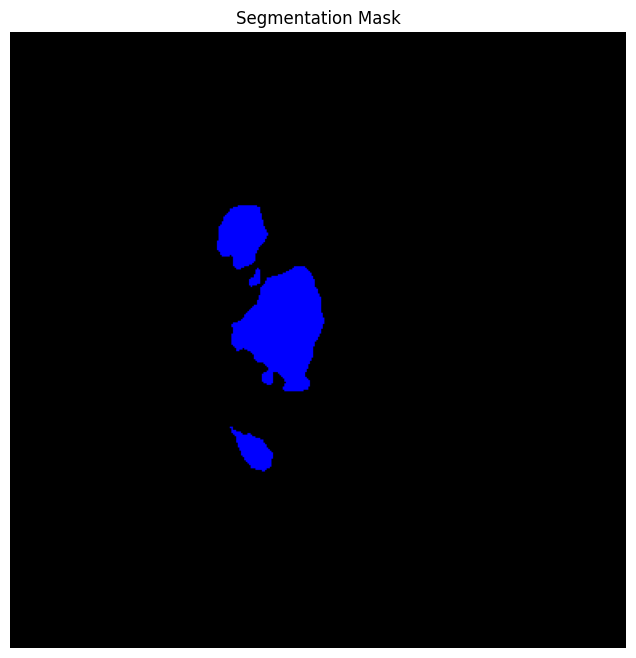

In [13]:
#from PIL import Image
import matplotlib.pyplot as plt

# Define color mapping for 4 classes (RGB values)
# Adjust colors as needed for your classes
color_map = {
    0: [0, 0, 0],      # Black (e.g., background)
    1: [255, 0, 0],    # Red (class 1)
    2: [0, 255, 0],    # Green (class 2)
    3: [0, 0, 255]     # Blue (class 3)
}

# Create RGB image from segmentation mask
mask_rgb = np.zeros((384, 384, 3), dtype=np.uint8)
for label in range(4):
    mask_rgb[segmentation_mask == label] = color_map[label]

# Convert to PIL Image
mask_image = Image.fromarray(mask_rgb)

# Save the mask
mask_image.save("segmentation_mask.png")
print("Segmentation mask saved as 'segmentation_mask.png'")

# Display the mask
plt.figure(figsize=(8, 8))
plt.imshow(mask_rgb)
plt.axis('off')
plt.title("Segmentation Mask")
plt.show()

Overlay saved as 'segmentation_overlay.png'


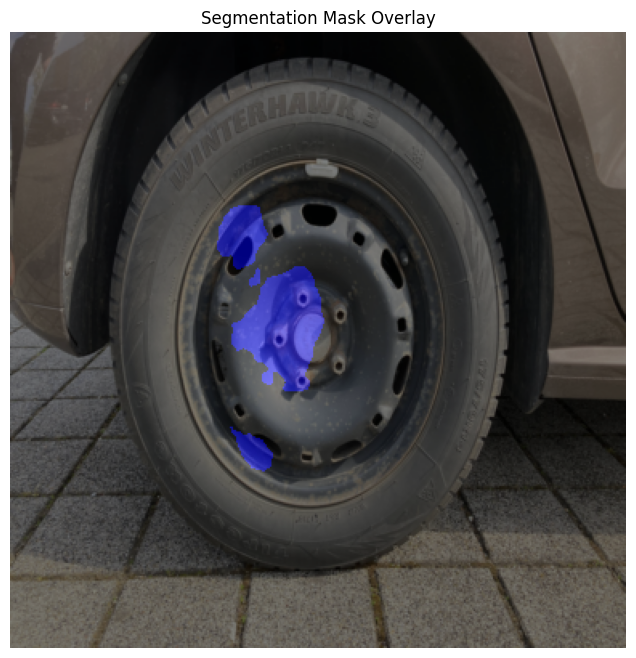

In [14]:
# Load original image
input_image = Image.open('41f9e920-51b7-44c3-b417-d9ceb0db9ebd.jpg').convert("RGB")
input_image = input_image.resize((384, 384), Image.BILINEAR)  # Match model input size
input_array = np.array(input_image)

# Create overlay (50% transparency for mask)
alpha = 0.5
overlay = (alpha * mask_rgb + (1 - alpha) * input_array).astype(np.uint8)

# Convert to PIL Image and save
overlay_image = Image.fromarray(overlay)
overlay_image.save("segmentation_overlay.png")
print("Overlay saved as 'segmentation_overlay.png'")

# Display overlay
plt.figure(figsize=(8, 8))
plt.imshow(overlay)
plt.axis('off')
plt.title("Segmentation Mask Overlay")
plt.show()

In [19]:
!pip freeze >requirement.txt